goal:

- use librosa on 1000 audio files and/or 50 class folders minimum
- store information in a dataframe (excluding actual file data for now)
  - folder name, file name, sampling rate, data length, file length, file size(?)

In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

from tqdm import tqdm
from IPython.display import Audio

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler

from math import floor

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def get_random_folders(base_dir: str, split_interval_secs: int | float, total_folders: int = 50, sample_rate: int = 32000, file_cutoff: int = 2000, folder_cutoff: int = 25, all_folder_files: bool = False, folder_size_range: tuple = (0, 0)):
    folders = os.listdir(base_dir)
    folder_count = 0
    random.shuffle(folders)

    rows = []

    for folder in folders:
        folder_dir = base_dir + folder + "/"

        folder_files = 0
        if folder_size_range != (0, 0):
            size = len(os.listdir(folder_dir))
            if size < folder_size_range[0] or size > folder_size_range[1]:
                continue

        for file in (progress_bar := tqdm(os.listdir(folder_dir))):
            file_data, file_sample_rate_hz = librosa.load(folder_dir + file, sr=sample_rate)

            total_splits = floor((len(file_data) / file_sample_rate_hz) / split_interval_secs) # floor(file length / split interval)

            if total_splits >= 1:
                split_size = int(file_sample_rate_hz * split_interval_secs)

                for split_offset in range(0, file_sample_rate_hz * total_splits + 1, split_size):
                    file_split_data = file_data[split_offset : split_offset + split_size]

                    spec_data = np.abs(librosa.stft(file_split_data)) # convert file data into mel-spectrogram fourier transform for feeding into CNN

                    row = [folder, file, len(file_split_data), file_sample_rate_hz, split_interval_secs, spec_data]
                    rows.append(row)

                    folder_files += 1
                
            if folder_files >= 200 and not all_folder_files: break
            progress_bar.set_description(f"Folder {folder_count + 1}/{total_folders} - {folder}")

        folder_count += 1

        if len(rows) >= file_cutoff and folder_count >= folder_cutoff and not all_folder_files: 
            print(f"Enumeration ended early due to having over {file_cutoff} files and at least {folder_cutoff} classes.")
            break

        if all_folder_files and folder_count >= total_folders: 
            break

    folder_df = pd.DataFrame(data=rows, columns=["folder", "file", "samples", "sample_rate_hz", "file_length_secs", "stft_data"])

    return folder_df

In [4]:
base_dir = "../datasets/birdsongs-combined/train_audio/"

# load the entire file and split the data. (interval of 10 seconds?) (remove anything that is under 10 seconds long)
split_interval_secs = 2 # change this as you please. CAN be a float i think?
sample_rate = 32000

# load 50 random files, cut off after 25 folders and 2000 files
#folder_df = get_random_folders(base_dir, split_interval_secs=2, total_folders=50, sample_rate=sample_rate, file_cutoff=2000, folder_cutoff=25)

# load ALL files from 10 random folders.
# prevent under/oversampling by setting a range of files per folder
folder_df = get_random_folders(base_dir, split_interval_secs=split_interval_secs, total_folders=25, sample_rate=sample_rate, all_folder_files=True, folder_size_range=(50,100))

Folder 25/25 - btbeat1: 100%|██████████| 57/57 [00:02<00:00, 25.27it/s]


In [5]:
len(folder_df)

24529

In [6]:
len(folder_df["folder"].unique())

25

<Axes: xlabel='folder'>

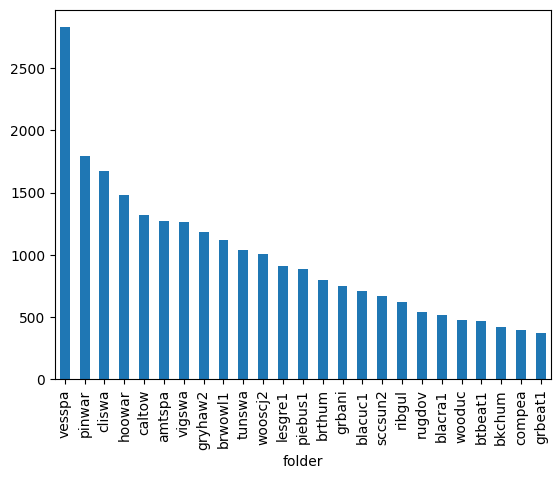

In [7]:
folder_df["folder"].value_counts().plot.bar()

In [8]:
# apply random undersampling OR oversampling

sampling_technique = "over"

if sampling_technique == "under":
    # random "naive" undersampling
    # delete random rows from all classes except minority class(es)
    min_folder_count = min(folder_df["folder"].value_counts())

    indices_to_keep = np.array([])

    for f in folder_df["folder"].unique():
        folder_length = len(folder_df[folder_df["folder"] == f])
        indices_to_keep = np.concat([np.random.choice(folder_df[folder_df["folder"] == f].index, size=min_folder_count), indices_to_keep])

    folder_df = folder_df.loc[indices_to_keep]
    folder_df.reset_index(drop=True, inplace=True)

if sampling_technique == "over":
    ros = RandomOverSampler(random_state=1368)

    # print how much each class will increase by (relative to its current size)
    max_folder = max(folder_df["folder"].value_counts())
    for folder, count in folder_df["folder"].value_counts().sort_values(ascending=True).items():
        print(f"{folder} will increase by {round((max_folder / count - 1) * 100, 2)}%")

    folder_df = pd.concat(ros.fit_resample(folder_df.drop("folder", axis=1), folder_df["folder"]), axis=1)
    # moves "folder" to other side of df but shouldn't affect anything

grbeat1 will increase by 662.53%
compea will increase by 612.59%
bkchum will increase by 576.79%
btbeat1 will increase by 499.36%
wooduc will increase by 498.1%
blacra1 will increase by 445.09%
rugdov will increase by 425.84%
ribgul will increase by 356.29%
sccsun2 will increase by 321.61%
blacuc1 will increase by 297.89%
grbani will increase by 277.7%
brthum will increase by 255.85%
piebus1 will increase by 218.94%
lesgre1 will increase by 209.52%
wooscj2 will increase by 180.1%
tunswa will increase by 171.24%
brwowl1 will increase by 152.14%
gryhaw2 will increase by 139.54%
vigswa will increase by 124.17%
amtspa will increase by 122.06%
caltow will increase by 114.81%
hoowar will increase by 90.51%
cliswa will increase by 68.79%
pinwar will increase by 57.6%
vesspa will increase by 0.0%


In [9]:
# while slightly slower, preserves memory as opposed to creating a list then copying it to DF, then deleting list

folder_df["mel_spec"] = None
folder_df["mel_spec_shape"] = None

for i in tqdm(folder_df.index):
    row = folder_df.iloc[i, :]

    spec_magnitude, _ = librosa.magphase(row["stft_data"])
    mel_scale_spectrogram = librosa.feature.melspectrogram(S=spec_magnitude, sr=row["sample_rate_hz"])
    mel_scale_spectrogram_db = librosa.amplitude_to_db(mel_scale_spectrogram, ref=np.min)

    folder_df["mel_spec"][i] = mel_scale_spectrogram_db
    folder_df["mel_spec_shape"][i] = mel_scale_spectrogram_db.shape


# stft data no longer needed after mel spectrogram transform?
folder_df.drop("stft_data", axis=1, inplace=True)

del i, row, spec_magnitude, mel_scale_spectrogram, mel_scale_spectrogram_db

100%|██████████| 70725/70725 [04:51<00:00, 242.42it/s]


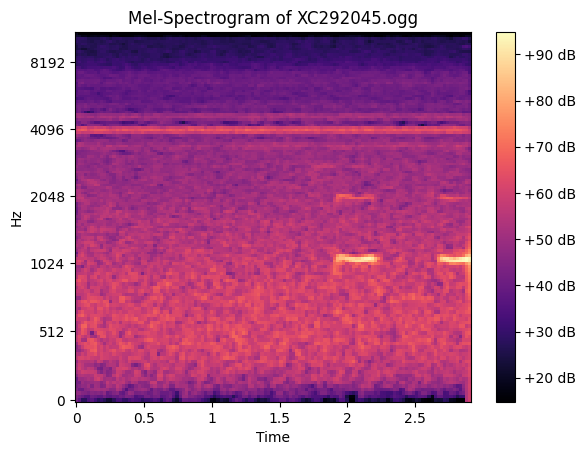

In [10]:
row = folder_df.iloc[random.randint(0, len(folder_df)), :]

plt.figure()
librosa.display.specshow(row["mel_spec"], x_axis="time", y_axis="mel")
plt.title(f"Mel-Spectrogram of {row["file"]}")
plt.colorbar(format='%+2.0f dB')
plt.show()

del row

In [11]:
# mel_spec_shape's x value is ALWAYS 128.

In [12]:
folder_df[["file_length_secs", "mel_spec_shape"]].value_counts()

# all of the same shape WHEN:
# - all file lengths are the same (customise interval at will)
# - sample rate is controlled. (e.g. 32000hz)

# 10 second file length + 32000 sampling rate = (128, 626) input shape
# 2 second file length + 32000 sampling rate = (128, 126) input shape

file_length_secs  mel_spec_shape
2                 (128, 126)        70725
Name: count, dtype: int64

In [13]:
# input shape needs to be AxBxCxD
# A = list of files
# B = depth of each one (currently just 1, as it only contains 1 value. if colours are used then maybe up it to 3)
# CxD = input width/height (128x626 etc)

x = torch.from_numpy(np.stack(folder_df["mel_spec"].values))
x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
x = x.to(device)

le = LabelEncoder()
y = torch.LongTensor(le.fit_transform(folder_df["folder"]))
y = y.to(device)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.3, random_state=1368)

del x, y

In [15]:
# create machine learning model.

class TestModel(nn.Module):
    global folder_df

    def __init__(self, input_shape: torch.Size, dropout_rate: float = 0):
        super().__init__()

        total_output_classes = len(folder_df["folder"].unique())

        # input shape should be some list/tuple of length 4
        if len(input_shape) != 4: return Exception("Input shape is not AxBxCxD.")

        # define layers here
        # assuming input shape = 1x128x126

        # conv2d: 1x128x126 -> 1x124x124 (kernel size = (5,3))
        # relu
        # max pool: 1x124x124 -> 1x62x62 (pool size = (2,2))
        # conv2d: 1x62x62 -> 1x60x60 (kernel size = (3, 3))
        # relu
        # max pool: 1x60x60 -> 1x30x30 (pool size = (2, 2))
        # flatten: 1x30x30 -> 900
        # linear: 900 -> 128
        # linear: 128 -> 32
        # linear: 32 -> (output layers)

        self.conv1 = nn.Conv2d(in_channels=input_shape[1], out_channels=1, kernel_size=(5, 3))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(p=dropout_rate)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout(p=dropout_rate)
        self.flat = nn.Flatten()
        self.linear1 = nn.Linear(in_features=900, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=32) 
        self.output = nn.Linear(in_features=32, out_features=total_output_classes)

    def forward(self, x):
        # define calculations here
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        x = self.drop1(x)
        x = self.relu2(self.conv2(x))
        x = self.pool2(x)
        x = self.drop2(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.output(x)

        return x

In [16]:
def train_model(model, loss_fn, optimizer, epochs, batch_size, save_best_to_file = False):
    batch_indices = np.linspace(0, len(x_train), int(len(x_train) / batch_size), dtype="int")

    train_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []

    best_test_acc = 0
    best_model = None

    for epoch in range(1, epochs + 1):
        model.train()

        train_acc = 0
        
        for i in range(len(batch_indices) - 1):
            start_index = batch_indices[i]
            stop_index = batch_indices[i + 1]

            x_batch = x_train[start_index:stop_index]
            y_batch = y_train[start_index:stop_index]

            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            train_acc += sum(torch.argmax(y_pred, dim=1) == y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_acc = train_acc * 100 / len(y_train)

        model.eval()
        test_acc = sum(torch.argmax(model(x_test), dim=1) == y_test) * 100 / len(y_test)

        print(f"Epoch {epoch}: train loss = {loss:.04f}, train acc = {train_acc:.02f}%, test acc = {test_acc:.02f}% {"!!" if test_acc > best_test_acc else ""}")

        train_loss_hist.append(float(loss.cpu().detach().numpy()))
        train_acc_hist.append(float(train_acc.cpu().detach().numpy()))
        test_acc_hist.append(float(test_acc.cpu().detach().numpy()))

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            
            # overwrite best model with new best model
            best_model = copy.deepcopy(model.state_dict())

    best_model_path = ""

    if save_best_to_file:
        model_save_path = "models/"

        if not os.path.exists(model_save_path): os.mkdir(model_save_path)

        file_number = len(os.listdir(model_save_path)) + 1

        file_name = f"best_model_{file_number:>03}"

        best_model_path = model_save_path + file_name + ".pth"

        torch.save(best_model, best_model_path)
        

    plt.figure(figsize=(12,8))
    pd.Series(train_acc_hist).plot.line(label="Train", color="blue")
    pd.Series(test_acc_hist).plot.line(label="Test", color="red")
    plt.legend()
    plt.ylim((0, 100))
    plt.yticks(np.arange(0, 101, 10))
    plt.title(f"Convolutional Neural Network on {len(folder_df)} files over {len(folder_df["folder"].unique())} folders.")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(axis="y")
    plt.show()

    return train_loss_hist, train_acc_hist, test_acc_hist, best_model

Epoch 1: train loss = 2.2314, train acc = 29.74%, test acc = 36.92% !!
Epoch 2: train loss = 1.8725, train acc = 41.60%, test acc = 41.73% !!
Epoch 3: train loss = 1.7393, train acc = 45.36%, test acc = 43.06% !!
Epoch 4: train loss = 1.6972, train acc = 47.20%, test acc = 43.87% !!
Epoch 5: train loss = 1.6769, train acc = 48.25%, test acc = 44.48% !!
Epoch 6: train loss = 1.6851, train acc = 48.87%, test acc = 44.46% 
Epoch 7: train loss = 1.6892, train acc = 49.36%, test acc = 43.87% 
Epoch 8: train loss = 1.6886, train acc = 49.86%, test acc = 44.65% !!
Epoch 9: train loss = 1.6824, train acc = 50.11%, test acc = 44.99% !!
Epoch 10: train loss = 1.6932, train acc = 50.38%, test acc = 45.40% !!
Epoch 11: train loss = 1.6780, train acc = 50.48%, test acc = 45.78% !!
Epoch 12: train loss = 1.6766, train acc = 50.68%, test acc = 45.75% 
Epoch 13: train loss = 1.6760, train acc = 50.63%, test acc = 45.01% 
Epoch 14: train loss = 1.6844, train acc = 50.82%, test acc = 45.27% 
Epoch 15: t

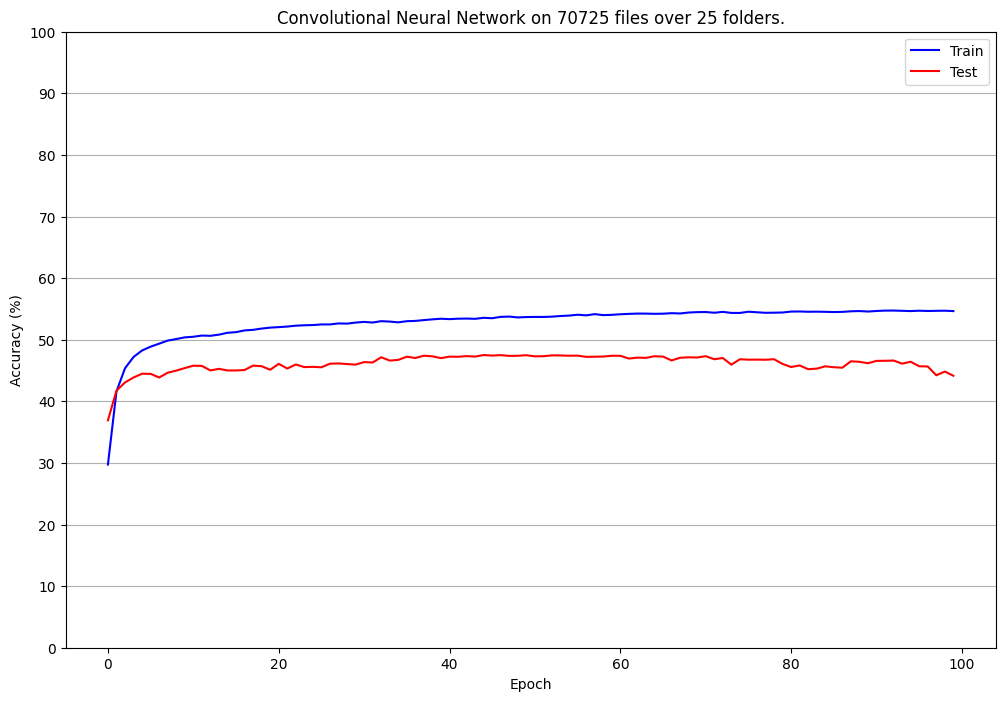

In [17]:
# to avoid extreme overfitting:
# - dropout rate between 0.2-0.5 seems good
# - learning rate around 0.001 provides best training rate without overfitting
# - train in larger batches, 64 upwards seems good
# - most seem to plateau around 200 epochs, maybe reduce to reduce total training time

epochs = 100
batch_size = 16
dropout_rate = 0
learning_rate = 0.001
momentum = 0

model = TestModel(input_shape=x_train.shape, dropout_rate=dropout_rate)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() # since we are classifying.
loss_fn = loss_fn.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate) # adam has no momentum, but DOES have weight decay

train_loss_hist, train_acc_hist, test_acc_hist, best_model = train_model(model, loss_fn, optimizer, epochs, batch_size, save_best_to_file=True)

In [18]:
# final results after testing approx. 30 different variations of dropout, learning rate, etc
# best learning rate = 0.001, batch size of 32/64, dropout rate around 0.2-0.5
# 200 epochs gives best results as test acc plateaus after that, prevents overfitting
# train/test split between 20-30% gives good results

In [19]:
# investigate TOP 5 ERROR of the model.
# compare with top 1 error (accuracy)

model.load_state_dict(best_model)
model.eval()

# get predictions for ALL testing data
k = 5
test_pred = model(x_test)
test_pred_top_k = torch.topk(test_pred, k=k, dim=1)[1]

total = 0
in_top_k = 0
for index, value in enumerate(y_test):
    if value in test_pred_top_k[index]: in_top_k += 1

    total += 1

top_k_accuracy = in_top_k * 100 / total

print(f"Top {k} Error: {top_k_accuracy:.03f}%")

Top 5 Error: 78.763%


In [79]:
accuracy_df = pd.DataFrame(data=[y_test.cpu().numpy(), test_pred_top_k.cpu().numpy()], index=["actual", "pred"]).transpose()
accuracy_df["in_top_5"] = [1 if accuracy_df.iloc[i, 0] in accuracy_df.iloc[i, 1] else 0 for i in range(len(accuracy_df.index))]
folder_top_5 = accuracy_df.groupby(by="actual").aggregate(func=np.sum)["in_top_5"].values
folder_counts = accuracy_df.groupby(by="actual").aggregate(func=np.size)["in_top_5"].values
accuracy_df = pd.DataFrame(data=[folder_top_5, folder_counts], index=["in_top_5", "count"]).transpose()
accuracy_df["top_5_accuracy"] = round(accuracy_df["in_top_5"] * 100 / accuracy_df["count"], 2)
accuracy_df.sort_values(by="top_5_accuracy")

,in_top_5,count,top_5_accuracy
24,531,854,62.18
7,549,861,63.76
19,550,856,64.25
16,545,824,66.14
13,566,855,66.20
21,574,849,67.61
10,599,868,69.01
8,604,830,72.77
20,623,845,73.73
12,611,819,74.60
